# Overview

From the analytic variance calculation, we can get that the Sobel formula is correct (although it has to distinguish between transitions a little bit more carefully than the Bellman equation).

Now we test our derived algorithm to see if it is capable of coming to the correct conclusions as well.

In [1]:
import numpy as np
from numpy.linalg import pinv
np.set_printoptions(precision=4, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Adjusted Analytic Expression

Note: it appears that there were issues w/ distinguishing the reward in the penultimate state-- it's either 0 or 1 with a certain probability, rather than 0.5 always.
After adding a terminal state with a reward of `1` to denote the bump event, the resulting approximation seems to agree with simulation.

In [2]:
# Chicken problem solved analytically
ns = 6
I = np.eye(ns)

# Probability of transitioning from state s_i --> s_j = P[i,j]
P = np.diag(np.ones(ns-1), 1) * 0.5
P[:,0] = 0.5
P[-1, 0] = 1

# Expected reward for transitioning from s_i --> s_j = R[i,j]
R = np.zeros((ns, ns))
R[-2, -1] = 1.0
r = np.sum(P*R, axis=1)

# Discount
gvec = np.ones(ns)*0.9
gvec[0] = 0
# gvec[-1] = 0
G = np.diag(gvec)

# Bootstrapping
L = np.eye(ns)*0.0

# Function approximation
X = np.eye(ns)


# Value function
v_pi = pinv(I - P @ G) @ r


# From sobel, recursive expected variance contribution?
T = -v_pi**2
for i in range(ns):
    for j in range(ns):
        T[i] += P[i,j] * (R[i,j] + gvec[j]*v_pi[j])**2

# Alternatively,
# T = np.sum(P * (R + G @ v_pi)**2, axis=1) - v_pi**2
        
# Variance (again from Sobel)
v_var = pinv(I - P @ G @ G) @ T 

print(v_pi)
print(T)
print(v_var)

[ 0.0205  0.0456  0.1013  0.225   0.5     0.    ]
[ 0.0004  0.0021  0.0103  0.0506  0.25   -0.    ]
[ 0.013   0.0311  0.0718  0.1519  0.25   -0.    ]


In [239]:
# From later simulations...
var_exp

array([ 0.0126,  0.0301,  0.0696,  0.1509,  0.25  ])

# Simulation

In [3]:
class Chicken:
    ACTIONS = {'advance': 0, 'return': 1}
    initial_state = 0
    def __init__(self, ns):
        self.length = ns - 1
        self.reset()
        
    def do(self, action):
        if action == 0:
            if self._state == self.length:
                sp = self.initial_state
            else:
                sp = self._state + 1
        elif action == 1:
            sp = self.initial_state
        else:
            raise Exception("Invalid action:", action)
        r = self.reward(self._state, action, sp)
        self._state = sp
        return r, sp
    
    def reward(self, s, a, sp):
        if s == self.length and a == self.ACTIONS['advance']:
            return 1
        else:
            return 0
        
    def reset(self):
        self._state = self.initial_state

    def observe(self):
        return self._state

In [4]:
def generate_steps(env, pol, nsteps):
    ret = []
    env.reset()
    for i in range(nsteps):
        s = env.observe()
        a = policy(s)
        r, sp = env.do(a)
        
        ret.append((s, a, r, sp))
    return ret

In [5]:
def create_episodes(steps, *terminals):
    ret = []
    epi = []
    terminals = set(terminals)
    for step in steps:
        s, a, r, sp = step
        epi.append((s, a, r, sp))
        if sp in terminals:
            ret.append(epi)
            epi = []
    return ret

In [6]:
def compute_return(steps, gmfunc):
    ret = []
    g = 0
    for step in reversed(steps):
        s, a, r, sp = step
        g = r + gmfunc(sp)*g
        ret.append((s, a, g, sp))
    return list(reversed(ret))

def compute_lambda_return(steps, gmfunc, lmfunc, vfunc):
    pass

In [7]:
def policy(s):
    return np.random.binomial(1, 0.5)

In [22]:
num_states = 5
slst = generate_steps(Chicken(num_states), policy, 50000)

In [23]:
gamma = lambda x: 0 if x == 0 else 0.9

In [24]:
glst = compute_return(slst, gamma)

In [25]:
gdf = pd.DataFrame(glst, columns=['s', 'a', 'g', 'sp'])

In [26]:
grouped = pd.groupby(gdf, 's')

In [27]:
grouped.aggregate({'g': np.mean})

g
s          
0  0.021298
1  0.047343
2  0.104500
3  0.232007
4  0.506667

In [28]:
grouped.aggregate({'g': np.var})

g
s          
0  0.013520
1  0.032274
2  0.073736
3  0.155027
4  0.250107

In [29]:
var_exp = grouped.aggregate({'g': np.var})['g'].as_matrix()

In [30]:
var_exp

array([ 0.0135,  0.0323,  0.0737,  0.155 ,  0.2501])

In [31]:
# Returns for each episode
#elst = [compute_return(ep, gamma) for ep in create_episodes(slst, 0)]

# Testing Algorithms on Simulated Data

In [32]:
class Int2Unary:
    """
    Convert integer to unary representation (e.g., for tabular case)
    """
    def __init__(self, length):
        self.length = length
        self._array = np.eye(length)

    def __call__(self, x):
        return self._array[x]

In [102]:
class TDVar_0:
    """Testing with known value function."""
    def __init__(self, n, w):
        """Initialize the learning algorithm.

        Parameters
        -----------
        n : int
            The number of features, i.e. expected length of the feature vector.
        """
        self.n = n
        self.reset()
        self.w = w

    def get_value(self, x):
        """Get the approximate value for feature vector `x`."""
        return np.dot(self.w, x)

    def get_variance(self, x):
        """Get the approximate variance for feature vector `x`."""
        return np.dot(self.u, x)
    
    def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
        """Update from new experience, i.e. from a transition `(x,r,xp)`."""
        delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)

        vg = gm_p**2 # implicitly saying lambda is one?
        vr = delta**2
        vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
        self.h = x
        self.u += beta*vd*self.h
        
    def reset(self):
        self.w = np.zeros(self.n)
        self.z = np.zeros(self.n)
        
        self.u = np.zeros(self.n)
        self.h = np.zeros(self.n)

In [103]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_0(num_features, v_pi[:-1])

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 0 if x == 0 else 0

# Simulation
for epoch in range(num_epochs):
    alpha = 0.1/(5*(epoch+1)) + 0.0001
    beta  = alpha/2
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()

0 0.0201 0.01005
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.013   0.0312  0.067   0.1416  0.25  ]

1 0.0101 0.00505
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0135  0.0316  0.0696  0.1449  0.25  ]

2 0.006766666666666667 0.0033833333333333337
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0137  0.0318  0.071   0.1474  0.25  ]

3 0.0051 0.00255
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0137  0.0319  0.0719  0.1491  0.25  ]

4 0.0041 0.00205
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0137  0.0319  0.0723  0.1503  0.25  ]

5 0.0034333333333333334 0.0017166666666666667
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0136  0.0319  0.0725  0.1512  0.25  ]

6 0.002957142857142857 0.0014785714285714285
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0135  0.0318  0.0726  0.1518  0.25  ]

7 0.0026 0.0013
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0135  0.0317  0.0727  0.1522  0.25  ]

8 0.002322222222222222 0.001161111111111111
[ 0.0205  0.0456  0.1013  0.225   0.5   ]
[ 0.0134  0.03

In [104]:
class TDVar_1:
    def __init__(self, n):
        """Initialize the learning algorithm.

        Parameters
        -----------
        n : int
            The number of features, i.e. expected length of the feature vector.
        """
        self.n = n
        self.reset()

    def get_value(self, x):
        """Get the approximate value for feature vector `x`."""
        return np.dot(self.w, x)

    def get_variance(self, x):
        """Get the approximate variance for feature vector `x`."""
        return np.dot(self.u, x)
    
    def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
        """Update from new experience, i.e. from a transition `(x,r,xp)`."""
        delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)
        self.z = x + gm*lm*self.z
        self.w += alpha*delta*self.z

        vg = gm_p**2 # implicitly saying lambda is one?
        vr = delta**2
        vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
        self.h = x
        self.u += beta*vd*self.h
        
    def reset(self):
        self.w = np.zeros(self.n)
        self.z = np.zeros(self.n)
        
        self.u = np.zeros(self.n)
        self.h = np.zeros(self.n)

In [105]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_1(num_features)

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 0 if x == 0 else 0

# Simulation
for epoch in range(num_epochs):
    alpha = 0.1/(5*(epoch+1)) + 0.0001
    beta  = alpha/2
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()

0 0.0201 0.01005
[ 0.0214  0.0499  0.095   0.2203  0.5773]
[ 0.0145  0.0348  0.0739  0.1558  0.2491]

1 0.0101 0.00505
[ 0.0224  0.0501  0.1024  0.2278  0.5707]
[ 0.0146  0.0342  0.0751  0.157   0.2482]

2 0.006766666666666667 0.0033833333333333337
[ 0.0222  0.0489  0.1024  0.2264  0.5619]
[ 0.0141  0.0328  0.0735  0.1548  0.2487]

3 0.0051 0.00255
[ 0.0219  0.0477  0.1013  0.2238  0.5527]
[ 0.0137  0.0321  0.0726  0.1533  0.2492]

4 0.0041 0.00205
[ 0.0216  0.047   0.1006  0.222   0.5448]
[ 0.0136  0.0319  0.0724  0.1527  0.2496]

5 0.0034333333333333334 0.0017166666666666667
[ 0.0215  0.0467  0.1005  0.2211  0.5386]
[ 0.0136  0.0319  0.0726  0.1526  0.2498]

6 0.002957142857142857 0.0014785714285714285
[ 0.0215  0.0467  0.1008  0.221   0.5337]
[ 0.0136  0.032   0.0728  0.1527  0.2499]

7 0.0026 0.0013
[ 0.0216  0.0468  0.1012  0.2214  0.5299]
[ 0.0137  0.0321  0.0731  0.1529  0.25  ]

8 0.002322222222222222 0.001161111111111111
[ 0.0216  0.0469  0.1018  0.222   0.5269]
[ 0.0137  0.03

In [192]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_1(num_features)

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 0 if x == 0 else 0

# Simulation
u_lst = []
h_lst = []
for epoch in range(num_epochs):
#     alpha = 0.1/(5*(epoch+1)) + 0.0001
#     beta  = 0.0001
    alpha = 0.005
    beta = 0.0005
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
        # Tracking
        u_lst.append(alg.u.copy())
        h_lst.append(alg.h.copy())
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()
    
h_lst = np.array(h_lst)
u_lst = np.array(u_lst)

0 0.005 0.0005
[ 0.0218  0.0475  0.1011  0.2235  0.5518]
[ 0.0049  0.0121  0.03    0.0722  0.1462]

1 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0095  0.0228  0.0535  0.1177  0.2046]

2 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0117  0.0278  0.0645  0.1385  0.2302]

3 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0127  0.0301  0.0695  0.1478  0.2414]

4 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0131  0.0312  0.0717  0.1519  0.2463]

5 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0133  0.0316  0.0727  0.1537  0.2485]

6 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0134  0.0318  0.0731  0.1545  0.2494]

7 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0134  0.0319  0.0733  0.1548  0.2498]

8 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0135  0.0319  0.0734  0.155   0.25  ]

9 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0135  0.032   0.0734  0.155   0.2501]



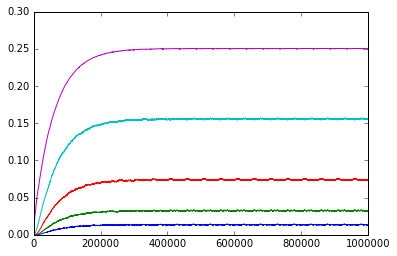

In [186]:
plt.plot(u_lst)

In [193]:
u_td1 = np.copy(u_lst)

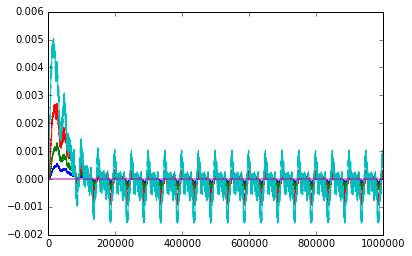

In [198]:
plt.plot(u_td2 - u_td1)

In [194]:
class TDVar_2:
    def __init__(self, n):
        """Initialize the learning algorithm.

        Parameters
        -----------
        n : int
            The number of features, i.e. expected length of the feature vector.
        """
        self.n = n
        self.reset()

    def get_value(self, x):
        """Get the approximate value for feature vector `x`."""
        return np.dot(self.w, x)

    def get_variance(self, x):
        """Get the approximate variance for feature vector `x`."""
        return np.dot(self.u, x)
    
    def update(self, x, r, xp, alpha, beta, gm, gm_p, lm):
        """Update from new experience, i.e. from a transition `(x,r,xp)`."""
        delta = r + gm_p*np.dot(self.w, xp) - np.dot(self.w, x)
        self.z = x + gm*lm*self.z
        self.w += alpha*delta*self.z

        vg = gm_p**2 # implicitly saying lambda is one?
        vr = delta**2
        vd = vr + vg*np.dot(self.u, xp) - np.dot(self.u, x)
        self.e = x
        self.u += beta*(vd*self.e + delta*self.h)
        self.h = gm_p*(x*delta) + gm*self.h
        
    def reset(self):
        self.w = np.zeros(self.n)
        self.z = np.zeros(self.n)
        
        self.u = np.zeros(self.n)
        self.e = np.zeros(self.n)
        self.h = np.zeros(self.n)

In [195]:
# Setup
num_epochs = 20
# Tabular case
num_features = num_states

# Algorithm
alg = TDVar_2(num_features)

# Representation
phi = Int2Unary(num_features)

# Parameters
gamma = lambda x: 0 if x == 0 else 0.9
lmbda = lambda x: 0 if x == 0 else 0

# Simulation
u_lst = []
h_lst = []
for epoch in range(num_epochs):
#     alpha = 0.1/(5*(epoch+1)) + 0.0001
#     beta  = 0.0001
    alpha = 0.005
    beta = 0.0005
    for step in slst:
        s, a, r, sp = step
        x = phi(s)
        xp = phi(sp)
        alg.update(x, r, xp, alpha, beta, gamma(s), gamma(sp), lmbda(s))
        
        # Tracking
        u_lst.append(alg.u.copy())
        h_lst.append(alg.h.copy())
        
    print(epoch, alpha, beta)
    print(alg.w)
    print(alg.u)
    print()
    
h_lst = np.array(h_lst)
u_lst = np.array(u_lst)

0 0.005 0.0005
[ 0.0218  0.0475  0.1011  0.2235  0.5518]
[ 0.0053  0.0129  0.0315  0.0749  0.1462]

1 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0096  0.023   0.0539  0.1189  0.2046]

2 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0117  0.0279  0.0647  0.1394  0.2302]

3 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0127  0.0302  0.0697  0.1486  0.2414]

4 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0131  0.0312  0.0719  0.1527  0.2463]

5 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0133  0.0317  0.0728  0.1545  0.2485]

6 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0134  0.0319  0.0733  0.1553  0.2494]

7 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0135  0.032   0.0734  0.1556  0.2498]

8 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0135  0.032   0.0735  0.1558  0.25  ]

9 0.005 0.0005
[ 0.0218  0.0476  0.1012  0.2236  0.552 ]
[ 0.0135  0.032   0.0736  0.1558  0.2501]



In [196]:
u_td2 = np.copy(u_lst)

In [ ]:
plt.plot(np.log(h_lst[:,-2]))[:100]

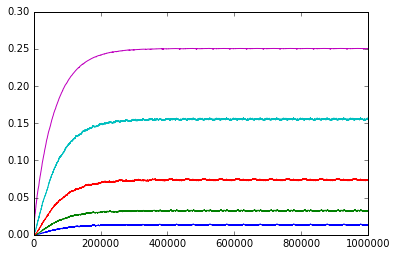

In [188]:
plt.plot(u_lst)

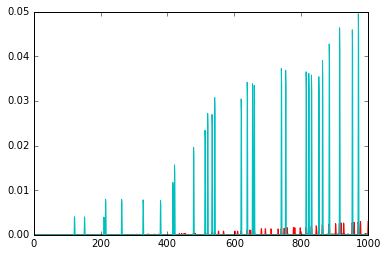

In [190]:
plt.plot(h_lst[:1000])

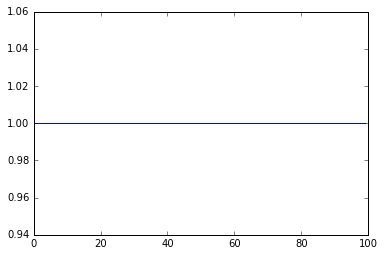

In [164]:
plt.plot(h_lst[:100,-2] == 0)